In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Flatten, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tools.eval_measures import meanabs, mse, rmse, rmspe

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL # seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm.notebook import tqdm
from itertools import product
from typing import Union


from prophet import Prophet

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [146]:
df = pd.read_csv(r"/content/drive/MyDrive/PECF.csv")
df.head()

,Date,Time,CountryCode,Value
0,2021-01-01,00:00:00,DE,42832.3525
1,2021-01-01,01:00:00,DE,41111.0725
2,2021-01-01,02:00:00,DE,40364.5550
3,2021-01-01,03:00:00,DE,40318.0775
4,2021-01-01,04:00:00,DE,39641.9450


In [147]:
df1 = df.drop(columns=["CountryCode"])
df1.head()

,Date,Time,Value
0,2021-01-01,00:00:00,42832.3525
1,2021-01-01,01:00:00,41111.0725
2,2021-01-01,02:00:00,40364.5550
3,2021-01-01,03:00:00,40318.0775
4,2021-01-01,04:00:00,39641.9450


In [148]:
df1['datetime'] = pd.to_datetime(df1['Date'] + ' ' + df1['Time'])

In [149]:
df1.head()

,Date,Time,Value,datetime
0,2021-01-01,00:00:00,42832.3525,2021-01-01 00:00:00
1,2021-01-01,01:00:00,41111.0725,2021-01-01 01:00:00
2,2021-01-01,02:00:00,40364.5550,2021-01-01 02:00:00
3,2021-01-01,03:00:00,40318.0775,2021-01-01 03:00:00
4,2021-01-01,04:00:00,39641.9450,2021-01-01 04:00:00


In [150]:
df1 =df1.drop(columns=["Date","Time"])
df1.head()

,Value,datetime
0,42832.3525,2021-01-01 00:00:00
1,41111.0725,2021-01-01 01:00:00
2,40364.5550,2021-01-01 02:00:00
3,40318.0775,2021-01-01 03:00:00
4,39641.9450,2021-01-01 04:00:00


In [151]:
df1.set_index('datetime', inplace=True)

In [152]:
df1.head()

,Value
datetime,
2021-01-01 00:00:00,42832.3525
2021-01-01 01:00:00,41111.0725
2021-01-01 02:00:00,40364.5550
2021-01-01 03:00:00,40318.0775
2021-01-01 04:00:00,39641.9450


In [153]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26280 entries, 2021-01-01 00:00:00 to 2023-12-31 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   26280 non-null  float64
dtypes: float64(1)
memory usage: 410.6 KB


In [154]:
timestamp_s = df1.index.map(pd.Timestamp.timestamp) # s seconds

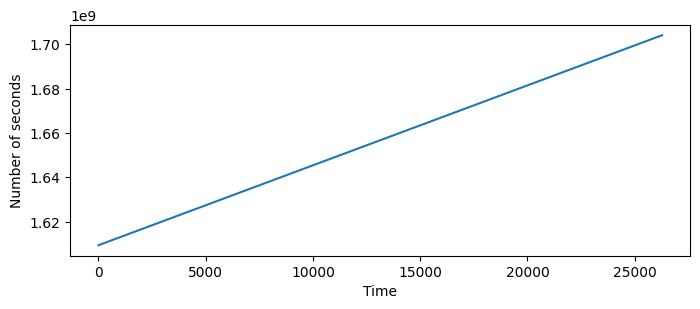

In [155]:
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(timestamp_s)
ax.set_xlabel('Time')
ax.set_ylabel('Number of seconds')
plt.show()

In [156]:
day = 24*60*60
year = (365.2425)*day

df1['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df1['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df1['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df1['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

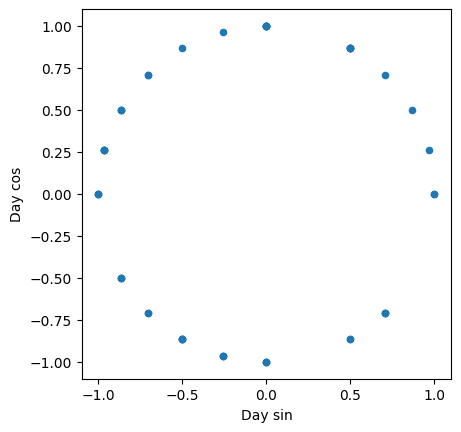

In [157]:
df1.sample(50).plot.scatter('Day sin','Day cos').set_aspect('equal')

In [158]:
fft = tf.signal.rfft(df['Value'])

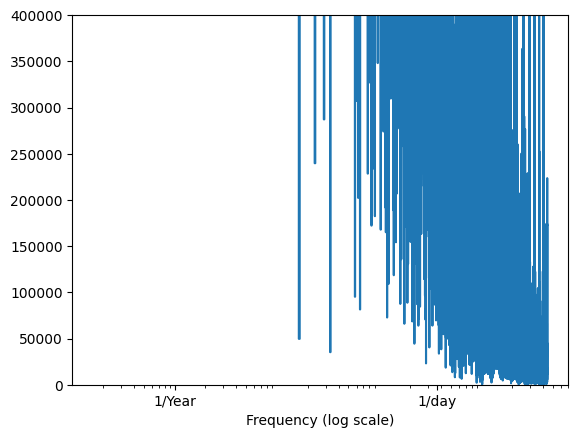

In [159]:
# fft = tf.signal.rfft(df['Global_active_power'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df1['Value'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [160]:
df1.head(2)

,Value,Day sin,Day cos,Year sin,Year cos
datetime,,,,,
2021-01-01 00:00:00,42832.3525,-6.012051e-12,1.000000,0.010881,0.999941
2021-01-01 01:00:00,41111.0725,2.588190e-01,0.965926,0.011597,0.999933


In [161]:
df1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Value,26280.0,5.499030e+04,9635.004684,30908.88,47219.418125,5.495611e+04,62529.151250,81077.455
Day sin,26280.0,2.055552e-15,0.707120,-1.00,-0.707107,1.403147e-14,0.707107,1.000
Day cos,26280.0,-4.118809e-15,0.707120,-1.00,-0.707107,1.452937e-14,0.707107,1.000
Year sin,26280.0,-2.833473e-06,0.707355,-1.00,-0.707474,-9.748239e-04,0.707454,1.000
Year cos,26280.0,-6.643732e-04,0.706885,-1.00,-0.707407,-1.042918e-03,0.705931,1.000


In [162]:
n = len(df1)

train_df = df1[:int(n*0.6)]
val_df = df1[int(n*0.6):int(n*0.8)]
test_df = df1[int(n*0.8):]

print(f'Length of train df: {len(train_df)}')
print(f'Length of val df: {len(val_df)}')
print(f'Length of test df: {len(test_df)}')

Length of train df: 15768
Length of val df: 5256
Length of test df: 5256


In [163]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

<ipython-input-164-493795098379>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(df.keys(), rotation=90)


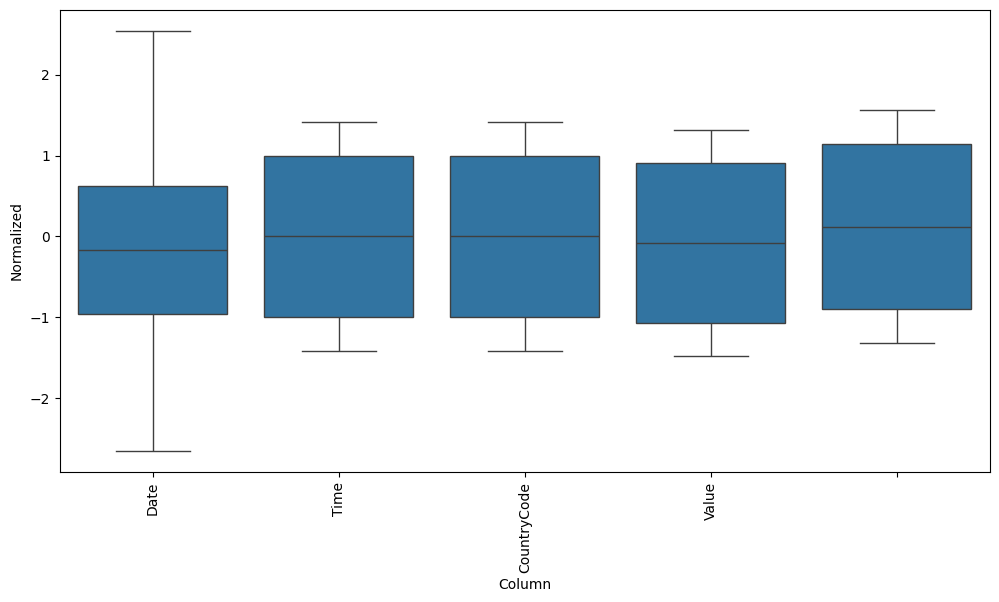

In [164]:
df_std = (df1 - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [165]:
df1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Value,26280.0,5.499030e+04,9635.004684,30908.88,47219.418125,5.495611e+04,62529.151250,81077.455
Day sin,26280.0,2.055552e-15,0.707120,-1.00,-0.707107,1.403147e-14,0.707107,1.000
Day cos,26280.0,-4.118809e-15,0.707120,-1.00,-0.707107,1.452937e-14,0.707107,1.000
Year sin,26280.0,-2.833473e-06,0.707355,-1.00,-0.707474,-9.748239e-04,0.707454,1.000
Year cos,26280.0,-6.643732e-04,0.706885,-1.00,-0.707407,-1.042918e-03,0.705931,1.000


In [166]:
df1.head(2)

,Value,Day sin,Day cos,Year sin,Year cos
datetime,,,,,
2021-01-01 00:00:00,42832.3525,-6.012051e-12,1.000000,0.010881,0.999941
2021-01-01 01:00:00,41111.0725,2.588190e-01,0.965926,0.011597,0.999933


In [167]:
# the function that splits data sets in subsets of 6 previous hours in X and the next hour in y
def data_for_deep_learning(df, window_size=6):
  numpy_data = df1.to_numpy()
  X = []
  y = []
  for i in range(len(numpy_data)-window_size):
      row = [inner_row for inner_row in numpy_data[i:i+window_size]]
      X.append(row)
      label = numpy_data[i+window_size][0] # with [0] we grab only the first column 'Global_active_power' that we want to predict
      y.append(label)
  return np.array(X), np.array(y)

In [168]:
X_train, y_train = data_for_deep_learning(train_df)
X_val, y_val = data_for_deep_learning(val_df)
X_test, y_test = data_for_deep_learning(test_df)

In [169]:
print(f'X train shape:')
print(X_train.shape)
print(f'y train shape:')
print(y_train.shape)
print(f'X val shape:')
print(X_val.shape)
print(f'y val shape:')
print(y_val.shape)
print(f'x test shape:')
print(X_test.shape)
print(f'y test shape:')
print(y_test.shape)

X train shape:
(26274, 6, 5)
y train shape:
(26274,)
X val shape:
(26274, 6, 5)
y val shape:
(26274,)
x test shape:
(26274, 6, 5)
y test shape:
(26274,)


In [170]:
# As an example we use the first 6 lines of train_df in
print(X_train[0])

[[ 4.28323525e+04 -6.01205130e-12  1.00000000e+00  1.08805418e-02
   9.99940805e-01]
 [ 4.11110725e+04  2.58819045e-01  9.65925826e-01  1.15972789e-02
   9.99932749e-01]
 [ 4.03645550e+04  5.00000000e-01  8.66025404e-01  1.23140100e-02
   9.99924180e-01]
 [ 4.03180775e+04  7.07106781e-01  7.07106781e-01  1.30307348e-02
   9.99915096e-01]
 [ 3.96419450e+04  8.66025404e-01  5.00000000e-01  1.37474530e-02
   9.99905499e-01]
 [ 3.90419075e+04  9.65925826e-01  2.58819045e-01  1.44641640e-02
   9.99895389e-01]]


In [171]:
# in order to predict the 7 hour only for Value
print(y_train[0])

39522.355


In [172]:
# A we see in the train set (train_df) in the first 7 hours
# the first 6 lines used in train set in X in the train set X_train[0]
# and only the Global_active_power in the 7 hour in label y in the train set y_train[0]
train_df.head(7)

,Value,Day sin,Day cos,Year sin,Year cos
datetime,,,,,
2021-01-01 00:00:00,-1.419640,-8.504191e-12,1.414169e+00,-0.070018,1.567226
2021-01-01 01:00:00,-1.598052,3.660138e-01,1.365982e+00,-0.069014,1.567215
2021-01-01 02:00:00,-1.675429,7.070844e-01,1.224706e+00,-0.068011,1.567202
2021-01-01 03:00:00,-1.680246,9.999683e-01,9.999683e-01,-0.067007,1.567189
2021-01-01 04:00:00,-1.750328,1.224706e+00,7.070844e-01,-0.066003,1.567175
2021-01-01 05:00:00,-1.812522,1.365982e+00,3.660138e-01,-0.064999,1.567161
2021-01-01 06:00:00,-1.762724,1.414169e+00,1.212161e-11,-0.063996,1.567146


In [173]:
# we create an empty dictionary to store mean absolute error of our models
mae = {}

In [174]:
#Linear model¶
#Note:
#In all models
#The input is (window size (timesteps), number of variables) = (6,5) because we use 6 previous features and our features are 5 (value, Day sin, Day cos, Year sin, Year cos)
#The last layer is 1 because we predicting 1 variable, the value

In [175]:
linear_model = Sequential()
linear_model.add(InputLayer(input_shape=(6, 5)))  # Adjust the shape here
linear_model.add(Flatten())
linear_model.add(Dense(1))


In [176]:
linear_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError()])

In [177]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, mode='min')

In [178]:
linear_model_checkpoint = ModelCheckpoint("linear_model.keras", save_best_only=True, monitor='val_loss')

In [179]:
linear_model = Sequential()
linear_model.add(InputLayer(input_shape=(6, 5)))
linear_model.add(Flatten())

linear_model.add(Dense(1))

# Compile the model
linear_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[MeanAbsoluteError()])

# Define callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=2, mode='min')
linear_model_checkpoint = ModelCheckpoint("linear_model.keras", save_best_only=True, monitor='val_loss')

# Train the model
history = linear_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[linear_model_checkpoint, early_stopping])

# Get the best model
best_model = load_model("linear_model.keras")

# Evaluate the best model on the test data
test_loss, test_mae = best_model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

Epoch 1/50
822/822 [==============================] - 3s 3ms/step - loss: 129169488.0000 - mean_absolute_error: 8744.9902 - val_loss: 84005824.0000 - val_mean_absolute_error: 7225.2363
Epoch 2/50
822/822 [==============================] - 2s 3ms/step - loss: 69607216.0000 - mean_absolute_error: 6662.7441 - val_loss: 55322100.0000 - val_mean_absolute_error: 5964.4106
Epoch 3/50
822/822 [==============================] - 2s 3ms/step - loss: 43013412.0000 - mean_absolute_error: 5223.0537 - val_loss: 32342650.0000 - val_mean_absolute_error: 4639.2256
Epoch 4/50
822/822 [==============================] - 4s 5ms/step - loss: 24155992.0000 - mean_absolute_error: 3873.9365 - val_loss: 17779160.0000 - val_mean_absolute_error: 3302.2502
Epoch 5/50
822/822 [==============================] - 3s 3ms/step - loss: 14123815.0000 - mean_absolute_error: 2892.6421 - val_loss: 11285578.0000 - val_mean_absolute_error: 2554.9124
Epoch 6/50
822/822 [==============================] - 2s 3ms/step - loss: 98415

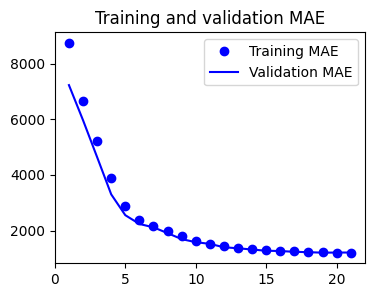

In [180]:
loss = linear_model.history.history["mean_absolute_error"]
val_loss = linear_model.history.history["val_mean_absolute_error"]
epochs = range(1, len(loss)+1)
plt.figure(figsize=(4,3))
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [181]:

results = pd.DataFrame(data=y_test, columns=['y_test_actual'])

In [182]:
results.head(2)

,y_test_actual
0,39522.3550
1,40628.3875


In [183]:
# Inverse transform of y test, because it was transformed with standar scaler
results['y_test_actual'] = results['y_test_actual'] * train_std['Value'] + train_mean['Value']

In [184]:
results.head(2)

,y_test_actual
0,3.813594e+08
1,3.920302e+08


In [185]:
results['linear_model_pred'] = linear_model.predict(X_test).flatten()

822/822 [==============================] - 1s 1ms/step


In [186]:
results.head(2)

,y_test_actual,linear_model_pred
0,3.813594e+08,38818.847656
1,3.920302e+08,39417.046875


In [187]:
results['linear_model_pred'] = results['linear_model_pred'] * train_std['Value'] + train_mean['Value']

In [188]:
results.head(2)

,y_test_actual,linear_model_pred
0,3.813594e+08,374572128.0
1,3.920302e+08,380343424.0


In [189]:
# We calculate and same MAE between y test (actual) and linear model predictions
mae['linear_model'] = mean_absolute_error(results['y_test_actual'], results['linear_model_pred']).round(3)

In [190]:
print(mae)

{'linear_model': 11708879.57}


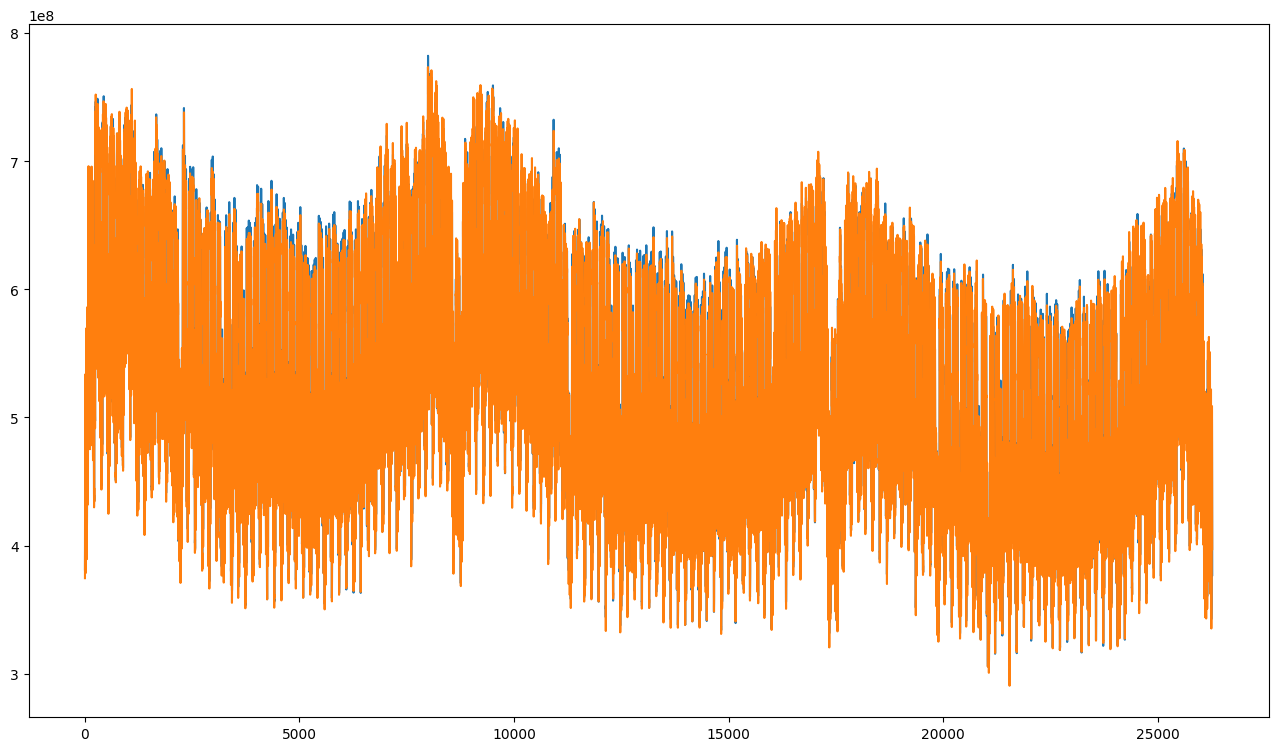

In [191]:
# example plot: actuals vs predictions on test set

results['y_test_actual'].plot(figsize=(16,9))
results['linear_model_pred'].plot()
plt.show()

In [192]:
#Dense (Deep Neural Network) model

In [193]:
dense_model = Sequential()
dense_model.add(InputLayer((6, 5)))
dense_model.add(Flatten())
dense_model.add(Dense(128, activation='relu'))
dense_model.add(Dense(128, activation='relu'))
dense_model.add(Dense(128, activation='relu'))
dense_model.add(Dense(1))
dense_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 30)                0         
                                                                 
 dense_24 (Dense)            (None, 128)               3968      
                                                                 
 dense_25 (Dense)            (None, 128)               16512     
                                                                 
 dense_26 (Dense)            (None, 128)               16512     
                                                                 
 dense_27 (Dense)            (None, 1)                 129       
                                                                 
Total params: 37121 (145.00 KB)
Trainable params: 37121 (145.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [194]:
dense_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError()])

dense_model_checkpoint = ModelCheckpoint("dense_model.keras", save_best_only=True, monitor='val_loss')

In [195]:
%%time

dense_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[dense_model_checkpoint, early_stopping])

Epoch 1/50
822/822 [==============================] - 5s 5ms/step - loss: 76215168.0000 - mean_absolute_error: 4523.4697 - val_loss: 5006098.0000 - val_mean_absolute_error: 1728.3400
Epoch 2/50
822/822 [==============================] - 3s 3ms/step - loss: 3663496.5000 - mean_absolute_error: 1427.6002 - val_loss: 2884626.7500 - val_mean_absolute_error: 1255.9371
Epoch 3/50
822/822 [==============================] - 3s 3ms/step - loss: 2733865.2500 - mean_absolute_error: 1230.7177 - val_loss: 2485369.7500 - val_mean_absolute_error: 1170.8527
Epoch 4/50
822/822 [==============================] - 3s 4ms/step - loss: 2390424.7500 - mean_absolute_error: 1143.2705 - val_loss: 2311382.5000 - val_mean_absolute_error: 1131.9750
Epoch 5/50
822/822 [==============================] - 4s 5ms/step - loss: 2100396.7500 - mean_absolute_error: 1062.9124 - val_loss: 2007869.5000 - val_mean_absolute_error: 1042.8978
Epoch 6/50
822/822 [==============================] - 3s 4ms/step - loss: 1918873.3750 - 

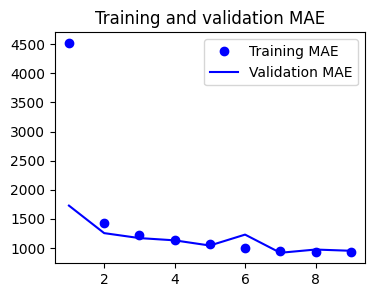

In [196]:
loss = dense_model.history.history["mean_absolute_error"]
val_loss = dense_model.history.history["val_mean_absolute_error"]
epochs = range(1, len(loss)+1)
plt.figure(figsize=(4,3))
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()


In [197]:
results['dense_model_pred'] = dense_model.predict(X_test).flatten()
results['dense_model_pred'] = results['dense_model_pred'] * train_std['Value'] + train_mean['Value']

822/822 [==============================] - 2s 2ms/step


In [198]:
results.head(2)

,y_test_actual,linear_model_pred,dense_model_pred
0,3.813594e+08,374572128.0,371100512.0
1,3.920302e+08,380343424.0,382643840.0


In [199]:
mae['dense_model'] = mean_absolute_error(results['y_test_actual'], results['dense_model_pred']).round(3)

In [200]:
print(mae)

{'linear_model': 11708879.57, 'dense_model': 9193502.042}


In [201]:
#cnn

In [202]:
conv_model = Sequential()
conv_model.add(InputLayer((6, 5)))
conv_model.add(Conv1D(32, kernel_size=2, activation='relu'))
conv_model.add(Flatten())
conv_model.add(Dense(32, activation='relu'))
conv_model.add(Dense(1))
conv_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 5, 32)             352       
                                                                 
 flatten_7 (Flatten)         (None, 160)               0         
                                                                 
 dense_28 (Dense)            (None, 32)                5152      
                                                                 
 dense_29 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5537 (21.63 KB)
Trainable params: 5537 (21.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [203]:
conv_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError()])

conv_model_checkpoint = ModelCheckpoint("conv_model.keras", save_best_only=True, monitor='val_loss')

In [204]:
%%time

conv_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[conv_model_checkpoint, early_stopping])

Epoch 1/50
822/822 [==============================] - 4s 4ms/step - loss: 233183984.0000 - mean_absolute_error: 9618.4502 - val_loss: 29125582.0000 - val_mean_absolute_error: 4242.3770
Epoch 2/50
822/822 [==============================] - 3s 3ms/step - loss: 23943500.0000 - mean_absolute_error: 3864.4397 - val_loss: 18657502.0000 - val_mean_absolute_error: 3435.4246
Epoch 3/50
822/822 [==============================] - 4s 5ms/step - loss: 14206030.0000 - mean_absolute_error: 2939.5969 - val_loss: 10484075.0000 - val_mean_absolute_error: 2537.6121
Epoch 4/50
822/822 [==============================] - 3s 4ms/step - loss: 8172001.5000 - mean_absolute_error: 2152.9336 - val_loss: 6669666.5000 - val_mean_absolute_error: 1887.3895
Epoch 5/50
822/822 [==============================] - 3s 3ms/step - loss: 5755734.5000 - mean_absolute_error: 1803.3666 - val_loss: 5157167.5000 - val_mean_absolute_error: 1752.6882
Epoch 6/50
822/822 [==============================] - 2s 3ms/step - loss: 4565551.0

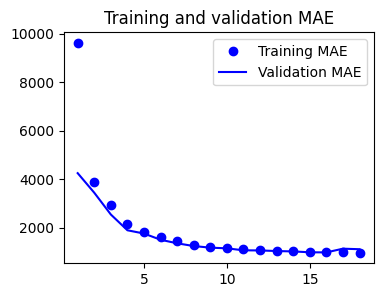

In [205]:
loss = conv_model.history.history["mean_absolute_error"]
val_loss = conv_model.history.history["val_mean_absolute_error"]
epochs = range(1, len(loss)+1)
plt.figure(figsize=(4,3))
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [206]:
results['conv_model_pred'] = conv_model.predict(X_test).flatten()
results['conv_model_pred'] = results['conv_model_pred'] * train_std['Value'] + train_mean['Value']

822/822 [==============================] - 1s 1ms/step


In [207]:
results.head(2)

,y_test_actual,linear_model_pred,dense_model_pred,conv_model_pred
0,3.813594e+08,374572128.0,371100512.0,369204800.0
1,3.920302e+08,380343424.0,382643840.0,381587968.0


In [208]:
mae['conv_model'] = mean_absolute_error(results['y_test_actual'], results['conv_model_pred']).round(3)

In [209]:
print(mae)

{'linear_model': 11708879.57, 'dense_model': 9193502.042, 'conv_model': 10673839.254}


In [210]:
# RNN (Recurrent Neural Network) - LSTM (Long short-term memory) model

In [211]:
lstm_model = Sequential()
lstm_model.add(InputLayer((6, 5)))
lstm_model.add(LSTM(32))
lstm_model.add(Dense(1))
lstm_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 32)                4864      
                                                                 
 dense_30 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4897 (19.13 KB)
Trainable params: 4897 (19.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [212]:
lstm_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError()])

lstm_model_checkpoint = ModelCheckpoint("lstm_model.keras", save_best_only=True, monitor='val_loss')

In [213]:
%%time

lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[lstm_model_checkpoint, early_stopping])

Epoch 1/50
822/822 [==============================] - 10s 10ms/step - loss: 3117006848.0000 - mean_absolute_error: 54992.7812 - val_loss: 3116973312.0000 - val_mean_absolute_error: 54992.4648
Epoch 2/50
822/822 [==============================] - 6s 8ms/step - loss: 3116937728.0000 - mean_absolute_error: 54992.1211 - val_loss: 3116900352.0000 - val_mean_absolute_error: 54991.7812
Epoch 3/50
822/822 [==============================] - 6s 8ms/step - loss: 3116867840.0000 - mean_absolute_error: 54991.5156 - val_loss: 3116832768.0000 - val_mean_absolute_error: 54991.2031
Epoch 4/50
822/822 [==============================] - 6s 8ms/step - loss: 3116797696.0000 - mean_absolute_error: 54990.8477 - val_loss: 3116762880.0000 - val_mean_absolute_error: 54990.6016
Epoch 5/50
822/822 [==============================] - 6s 8ms/step - loss: 3116724224.0000 - mean_absolute_error: 54990.1992 - val_loss: 3116692224.0000 - val_mean_absolute_error: 54989.9141
Epoch 6/50
822/822 [============================

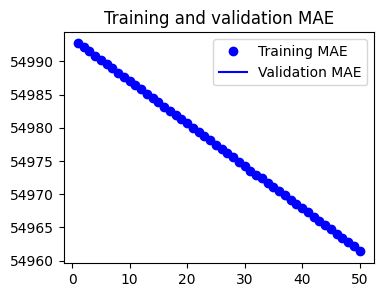

In [214]:
loss = lstm_model.history.history["mean_absolute_error"]
val_loss = lstm_model.history.history["val_mean_absolute_error"]
epochs = range(1, len(loss)+1)
plt.figure(figsize=(4,3))
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [215]:
results['lstm_model_pred'] = lstm_model.predict(X_test).flatten()
results['lstm_model_pred'] = results['lstm_model_pred'] * train_std['Value'] + train_mean['Value']

822/822 [==============================] - 2s 2ms/step


In [216]:
results.head(2)

,y_test_actual,linear_model_pred,dense_model_pred,conv_model_pred,lstm_model_pred
0,3.813594e+08,374572128.0,371100512.0,369204800.0,369104.6875
1,3.920302e+08,380343424.0,382643840.0,381587968.0,369104.6875


In [217]:
mae['lstm_model'] = mean_absolute_error(results['y_test_actual'], results['lstm_model_pred']).round(3)

In [218]:
print(mae)

{'linear_model': 11708879.57, 'dense_model': 9193502.042, 'conv_model': 10673839.254, 'lstm_model': 530253440.464}


In [219]:
#RNN (Recurrent Neural Network) - GRU (Gated Recurrent Unit) model

In [220]:
gru_model = Sequential()
gru_model.add(InputLayer((6, 5)))
gru_model.add(GRU(64))
gru_model.add(Dense(1))
gru_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 64)                13632     
                                                                 
 dense_31 (Dense)            (None, 1)                 65        
                                                                 
Total params: 13697 (53.50 KB)
Trainable params: 13697 (53.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [221]:
gru_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError()])

gru_model_checkpoint = ModelCheckpoint("gru_model.keras", save_best_only=True, monitor='val_loss')

In [222]:
%%time

gru_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[gru_model_checkpoint, early_stopping])

Epoch 1/50
822/822 [==============================] - 11s 10ms/step - loss: 3117124864.0000 - mean_absolute_error: 54993.8438 - val_loss: 3116976640.0000 - val_mean_absolute_error: 54992.4961
Epoch 2/50
822/822 [==============================] - 6s 8ms/step - loss: 3116829952.0000 - mean_absolute_error: 54991.1133 - val_loss: 3116679168.0000 - val_mean_absolute_error: 54989.7617
Epoch 3/50
822/822 [==============================] - 8s 9ms/step - loss: 3116530176.0000 - mean_absolute_error: 54988.4102 - val_loss: 3116382464.0000 - val_mean_absolute_error: 54987.1133
Epoch 4/50
822/822 [==============================] - 7s 8ms/step - loss: 3116229376.0000 - mean_absolute_error: 54985.7227 - val_loss: 3116083456.0000 - val_mean_absolute_error: 54984.3516
Epoch 5/50
822/822 [==============================] - 9s 11ms/step - loss: 3115934208.0000 - mean_absolute_error: 54982.9805 - val_loss: 3115784192.0000 - val_mean_absolute_error: 54981.6055
Epoch 6/50
822/822 [===========================

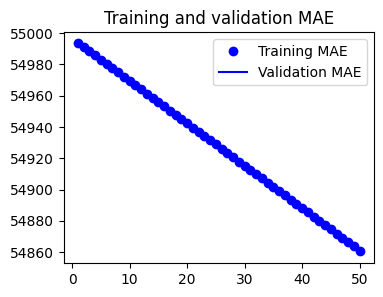

In [223]:
loss = gru_model.history.history["mean_absolute_error"]
val_loss = gru_model.history.history["val_mean_absolute_error"]
epochs = range(1, len(loss)+1)
plt.figure(figsize=(4,3))
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [224]:
results['gru_model_pred'] = gru_model.predict(X_test).flatten()
results['gru_model_pred'] = results['gru_model_pred'] * train_std['Value'] + train_mean['Value']

822/822 [==============================] - 2s 2ms/step


In [225]:
results.head(2)

,y_test_actual,linear_model_pred,dense_model_pred,conv_model_pred,lstm_model_pred,gru_model_pred
0,3.813594e+08,374572128.0,371100512.0,369204800.0,369104.6875,1348918.375
1,3.920302e+08,380343424.0,382643840.0,381587968.0,369104.6875,1348918.375


In [226]:
mae['gru_model'] = mean_absolute_error(results['y_test_actual'], results['gru_model_pred']).round(3)

In [227]:
print(mae)

{'linear_model': 11708879.57, 'dense_model': 9193502.042, 'conv_model': 10673839.254, 'lstm_model': 530253440.464, 'gru_model': 529273626.777}


In [228]:
#CNN + LSTM model

In [229]:
cnn_lstm_model = Sequential()
cnn_lstm_model.add(InputLayer((6, 5)))
cnn_lstm_model.add(Conv1D(32, activation='relu', kernel_size=2))
cnn_lstm_model.add(LSTM(32))
cnn_lstm_model.add(Dense(32, activation='relu')) # me added
cnn_lstm_model.add(Dense(1))
cnn_lstm_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 5, 32)             352       
                                                                 
 lstm_6 (LSTM)               (None, 32)                8320      
                                                                 
 dense_32 (Dense)            (None, 32)                1056      
                                                                 
 dense_33 (Dense)            (None, 1)                 33        
                                                                 
Total params: 9761 (38.13 KB)
Trainable params: 9761 (38.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [230]:
cnn_lstm_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError()])

cnn_lstm_model_checkpoint = ModelCheckpoint("cnn_lstm_model.keras", save_best_only=True, monitor='val_loss')

In [231]:
%%time

cnn_lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[cnn_lstm_model_checkpoint, early_stopping])

Epoch 1/50
822/822 [==============================] - 9s 8ms/step - loss: 3117022976.0000 - mean_absolute_error: 54992.8867 - val_loss: 3116941056.0000 - val_mean_absolute_error: 54992.1367
Epoch 2/50
822/822 [==============================] - 6s 8ms/step - loss: 3116845568.0000 - mean_absolute_error: 54991.2969 - val_loss: 3116738304.0000 - val_mean_absolute_error: 54990.3164
Epoch 3/50
822/822 [==============================] - 7s 8ms/step - loss: 3116601856.0000 - mean_absolute_error: 54989.1016 - val_loss: 3116452352.0000 - val_mean_absolute_error: 54987.6758
Epoch 4/50
822/822 [==============================] - 6s 8ms/step - loss: 3116272128.0000 - mean_absolute_error: 54986.0977 - val_loss: 3116083200.0000 - val_mean_absolute_error: 54984.3398
Epoch 5/50
822/822 [==============================] - 6s 7ms/step - loss: 3115870464.0000 - mean_absolute_error: 54982.4102 - val_loss: 3115648768.0000 - val_mean_absolute_error: 54980.4180
Epoch 6/50
822/822 [==============================

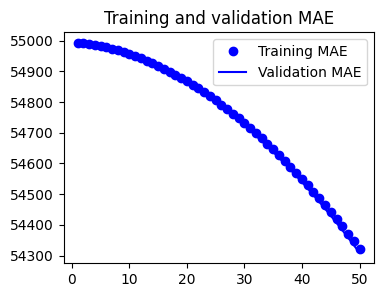

In [232]:
loss = cnn_lstm_model.history.history["mean_absolute_error"]
val_loss = cnn_lstm_model.history.history["val_mean_absolute_error"]
epochs = range(1, len(loss)+1)
plt.figure(figsize=(4,3))
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [233]:
results['cnn_lstm_model_pred'] = cnn_lstm_model.predict(X_test).flatten()
results['cnn_lstm_model_pred'] = results['cnn_lstm_model_pred'] * train_std['Value'] + train_mean['Value']

822/822 [==============================] - 2s 2ms/step


In [234]:
results.head(2)

,y_test_actual,linear_model_pred,dense_model_pred,conv_model_pred,lstm_model_pred,gru_model_pred,cnn_lstm_model_pred
0,3.813594e+08,374572128.0,371100512.0,369204800.0,369104.6875,1348918.375,6662493.0
1,3.920302e+08,380343424.0,382643840.0,381587968.0,369104.6875,1348918.375,6662493.0


In [235]:
mae['cnn_lstm_model'] = mean_absolute_error(results['y_test_actual'], results['cnn_lstm_model_pred']).round(3)

In [236]:
print(mae)

{'linear_model': 11708879.57, 'dense_model': 9193502.042, 'conv_model': 10673839.254, 'lstm_model': 530253440.464, 'gru_model': 529273626.777, 'cnn_lstm_model': 523960052.152}


In [237]:
#CNN + GRU model

In [238]:
cnn_gru_model = Sequential()
cnn_gru_model.add(InputLayer((6, 5)))
cnn_gru_model.add(Conv1D(32, activation='relu', kernel_size=2))
cnn_gru_model.add(GRU(32))
cnn_gru_model.add(Dense(units=32, activation='relu')) # me added
cnn_gru_model.add(Dense(1))
cnn_gru_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 5, 32)             352       
                                                                 
 gru_6 (GRU)                 (None, 32)                6336      
                                                                 
 dense_34 (Dense)            (None, 32)                1056      
                                                                 
 dense_35 (Dense)            (None, 1)                 33        
                                                                 
Total params: 7777 (30.38 KB)
Trainable params: 7777 (30.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [239]:
cnn_gru_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError()])

cnn_gru_model_checkpoint = ModelCheckpoint("cnn_gru_model.keras", save_best_only=True, monitor='val_loss')

In [ ]:
%%time

cnn_gru_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[cnn_gru_model_checkpoint, early_stopping])

Epoch 1/50
822/822 [==============================] - 9s 8ms/step - loss: 3116921856.0000 - mean_absolute_error: 54992.0273 - val_loss: 3116746240.0000 - val_mean_absolute_error: 54990.4219
Epoch 2/50
815/822 [============================>.] - ETA: 0s - loss: 3116018944.0000 - mean_absolute_error: 54983.3242

In [ ]:
loss = cnn_gru_model.history.history["mean_absolute_error"]
val_loss = cnn_gru_model.history.history["val_mean_absolute_error"]
epochs = range(1, len(loss)+1)
plt.figure(figsize=(4,3))
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
results['cnn_gru_model_pred'] = cnn_gru_model.predict(X_test).flatten()
results['cnn_gru_model_pred'] = results['cnn_gru_model_pred'] * train_std['Value'] + train_mean['Value']

In [ ]:
results.head(2)

In [ ]:
mae['cnn_gru_model'] = mean_absolute_error(results['y_test_actual'], results['cnn_gru_model_pred']).round(3)

In [ ]:
print(mae)

In [ ]:
#LSTM with hidden layer model

In [ ]:
lstm_dense_model = Sequential()
lstm_dense_model.add(InputLayer((6, 5)))
lstm_dense_model.add(LSTM(64))
lstm_dense_model.add(Dense(units=8, activation='relu'))
lstm_dense_model.add(Dense(1))
lstm_dense_model.summary()

In [ ]:
lstm_dense_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError()])

lstm_dense_model_checkpoint = ModelCheckpoint("lstm_dense_model.keras", save_best_only=True, monitor='val_loss')

In [ ]:
%%time

lstm_dense_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[lstm_dense_model_checkpoint, early_stopping])

In [ ]:
loss = lstm_dense_model.history.history["mean_absolute_error"]
val_loss = lstm_dense_model.history.history["val_mean_absolute_error"]
epochs = range(1, len(loss)+1)
plt.figure(figsize=(4,3))
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
results['lstm_dense_model_pred'] = lstm_dense_model.predict(X_test).flatten()
results['lstm_dense_model_pred'] = results['lstm_dense_model_pred'] * train_std['Value'] + train_mean['Value']

In [ ]:
results.head(2)


In [ ]:
mae['lstm_dense_model'] = mean_absolute_error(results['y_test_actual'], results['lstm_dense_model_pred']).round(3)

In [ ]:
print(mae)

In [ ]:
#GRU with hidden layer model

In [ ]:
gru_dense_model = Sequential()
gru_dense_model.add(InputLayer((6, 5)))
gru_dense_model.add(GRU(64))
gru_dense_model.add(Dense(units=8, activation='relu'))
gru_dense_model.add(Dense(1))
gru_dense_model.summary()

In [ ]:
gru_dense_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError()])

gru_dense_model_checkpoint = ModelCheckpoint("gru_dense_model.keras", save_best_only=True, monitor='val_loss')

In [ ]:
%%time

gru_dense_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[gru_dense_model_checkpoint, early_stopping])

In [ ]:
loss = gru_dense_model.history.history["mean_absolute_error"]
val_loss = gru_dense_model.history.history["val_mean_absolute_error"]
epochs = range(1, len(loss)+1)
plt.figure(figsize=(4,3))
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
results['gru_dense_model_pred'] = gru_dense_model.predict(X_test).flatten()
results['gru_dense_model_pred'] = results['gru_dense_model_pred'] * train_std['Value'] + train_mean['Value']

In [ ]:
results.head(2)

In [ ]:
mae['gru_dense_model'] = mean_absolute_error(results['y_test_actual'], results['gru_dense_model_pred']).round(3)

In [ ]:
print(mae)

In [ ]:
#Stacked LSTM model with hidden layer

In [ ]:
stacked_lstm_model = Sequential()
stacked_lstm_model.add(InputLayer((6, 5)))
stacked_lstm_model.add(LSTM(32, return_sequences=True))
stacked_lstm_model.add(LSTM(64))
stacked_lstm_model.add(Dense(8, activation='relu'))
stacked_lstm_model.add(Dense(1))
stacked_lstm_model.summary()

In [ ]:
stacked_lstm_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError()])

stacked_lstm_model_checkpoint = ModelCheckpoint("stacked_lstm_model.keras", save_best_only=True, monitor='val_loss')

In [123]:
%%time

stacked_lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[stacked_lstm_model_checkpoint, early_stopping])

Epoch 1/50
822/822 [==============================] - 15s 13ms/step - loss: 3116454656.0000 - mean_absolute_error: 54987.6953 - val_loss: 3115927808.0000 - val_mean_absolute_error: 54983.0117
Epoch 2/50
822/822 [==============================] - 12s 14ms/step - loss: 3115405056.0000 - mean_absolute_error: 54978.2344 - val_loss: 3114834688.0000 - val_mean_absolute_error: 54973.0430
Epoch 3/50
822/822 [==============================] - 9s 11ms/step - loss: 3114179328.0000 - mean_absolute_error: 54967.0547 - val_loss: 3113473536.0000 - val_mean_absolute_error: 54960.6523
Epoch 4/50
822/822 [==============================] - 10s 12ms/step - loss: 3112689920.0000 - mean_absolute_error: 54953.4453 - val_loss: 3111856640.0000 - val_mean_absolute_error: 54945.9336
Epoch 5/50
822/822 [==============================] - 10s 12ms/step - loss: 3110947328.0000 - mean_absolute_error: 54937.6602 - val_loss: 3109995264.0000 - val_mean_absolute_error: 54928.9844
Epoch 6/50
822/822 [=====================

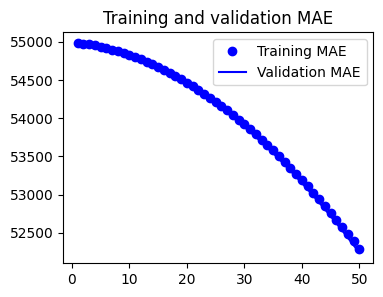

In [124]:
loss = stacked_lstm_model.history.history["mean_absolute_error"]
val_loss = stacked_lstm_model.history.history["val_mean_absolute_error"]
epochs = range(1, len(loss)+1)
plt.figure(figsize=(4,3))
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [125]:
results['stacked_lstm_model_pred'] = stacked_lstm_model.predict(X_test).flatten()
results['stacked_lstm_model_pred'] = results['stacked_lstm_model_pred'] * train_std['Value'] + train_mean['Value']

822/822 [==============================] - 3s 3ms/step


In [126]:
results.head(2)

,y_test_actual,linear_model_pred,dense_model_pred,conv_model_pred,lstm_model_pred,gru_model_pred,cnn_lstm_model_pred,cnn_gru_model_pred,lstm_dense_model_pred,gru_dense_model_pred,stacked_lstm_model_pred
0,3.813594e+08,375536128.0,376317216.0,377055104.0,360080.71875,1392402.125,27350386.0,20147692.0,3265998.75,19475578.0,26639118.0
1,3.920302e+08,381996512.0,389812992.0,389982624.0,360080.71875,1392402.125,27350386.0,20147692.0,3265998.75,19475578.0,26639118.0


In [127]:
mae['stacked_lstm_model'] = mean_absolute_error(results['y_test_actual'], results['stacked_lstm_model_pred']).round(3)

In [128]:
print(mae)

{'linear_model': 11017228.222, 'dense_model': 8327609.297, 'conv_model': 9720750.763, 'lstm_model': 530262464.433, 'gru_model': 529230143.027, 'cnn_lstm_model': 503272159.152, 'cnn_gru_model': 510474853.152, 'lstm_dense_model': 527356546.402, 'gru_dense_model': 511146967.152, 'stacked_lstm_model': 503983427.152}


In [129]:
#Stacked GRU model with hidden layer

In [130]:
stacked_gru_model = Sequential()
stacked_gru_model.add(InputLayer((6, 5)))
stacked_gru_model.add(GRU(32, return_sequences=True))
stacked_gru_model.add(GRU(64))
stacked_gru_model.add(Dense(8, activation='relu'))
stacked_gru_model.add(Dense(1))
stacked_gru_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 6, 32)             3744      
                                                                 
 gru_4 (GRU)                 (None, 64)                18816     
                                                                 
 dense_20 (Dense)            (None, 8)                 520       
                                                                 
 dense_21 (Dense)            (None, 1)                 9         
                                                                 
Total params: 23089 (90.19 KB)
Trainable params: 23089 (90.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [131]:
stacked_gru_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError()])

stacked_gru_model_checkpoint = ModelCheckpoint("stacked_gru_model.keras", save_best_only=True, monitor='val_loss')

In [132]:
%%time

stacked_gru_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[stacked_gru_model_checkpoint, early_stopping])

Epoch 1/50
822/822 [==============================] - 14s 11ms/step - loss: 3116446464.0000 - mean_absolute_error: 54987.6719 - val_loss: 3115698688.0000 - val_mean_absolute_error: 54980.8555
Epoch 2/50
822/822 [==============================] - 10s 12ms/step - loss: 3114864640.0000 - mean_absolute_error: 54973.3203 - val_loss: 3113930496.0000 - val_mean_absolute_error: 54964.7578
Epoch 3/50
822/822 [==============================] - 11s 13ms/step - loss: 3112801024.0000 - mean_absolute_error: 54954.5391 - val_loss: 3111576832.0000 - val_mean_absolute_error: 54943.3359
Epoch 4/50
822/822 [==============================] - 9s 11ms/step - loss: 3110179584.0000 - mean_absolute_error: 54930.7383 - val_loss: 3108694016.0000 - val_mean_absolute_error: 54917.1250
Epoch 5/50
822/822 [==============================] - 10s 12ms/step - loss: 3107049984.0000 - mean_absolute_error: 54902.1406 - val_loss: 3105318656.0000 - val_mean_absolute_error: 54886.4336
Epoch 6/50
822/822 [=====================

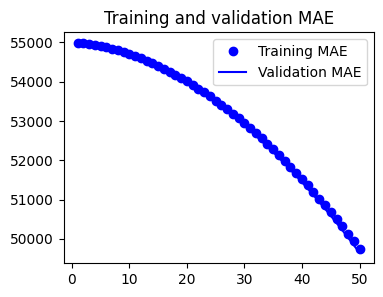

In [133]:
loss = stacked_gru_model.history.history["mean_absolute_error"]
val_loss = stacked_gru_model.history.history["val_mean_absolute_error"]
epochs = range(1, len(loss)+1)
plt.figure(figsize=(4,3))
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [134]:
results['stacked_gru_model_pred'] = stacked_gru_model.predict(X_test).flatten()
results['stacked_gru_model_pred'] = results['stacked_gru_model_pred'] * train_std['Value'] + train_mean['Value']

822/822 [==============================] - 3s 3ms/step


In [135]:
results.head(2)

,y_test_actual,linear_model_pred,dense_model_pred,conv_model_pred,lstm_model_pred,gru_model_pred,cnn_lstm_model_pred,cnn_gru_model_pred,lstm_dense_model_pred,gru_dense_model_pred,stacked_lstm_model_pred,stacked_gru_model_pred
0,3.813594e+08,375536128.0,376317216.0,377055104.0,360080.71875,1392402.125,27350386.0,20147692.0,3265998.75,19475578.0,26639118.0,51630356.0
1,3.920302e+08,381996512.0,389812992.0,389982624.0,360080.71875,1392402.125,27350386.0,20147692.0,3265998.75,19475578.0,26639118.0,51630356.0


In [136]:
mae['stacked_gru_model'] = mean_absolute_error(results['y_test_actual'], results['stacked_gru_model_pred']).round(3)

In [137]:
print(mae)

{'linear_model': 11017228.222, 'dense_model': 8327609.297, 'conv_model': 9720750.763, 'lstm_model': 530262464.433, 'gru_model': 529230143.027, 'cnn_lstm_model': 503272159.152, 'cnn_gru_model': 510474853.152, 'lstm_dense_model': 527356546.402, 'gru_dense_model': 511146967.152, 'stacked_lstm_model': 503983427.152, 'stacked_gru_model': 478992189.152}


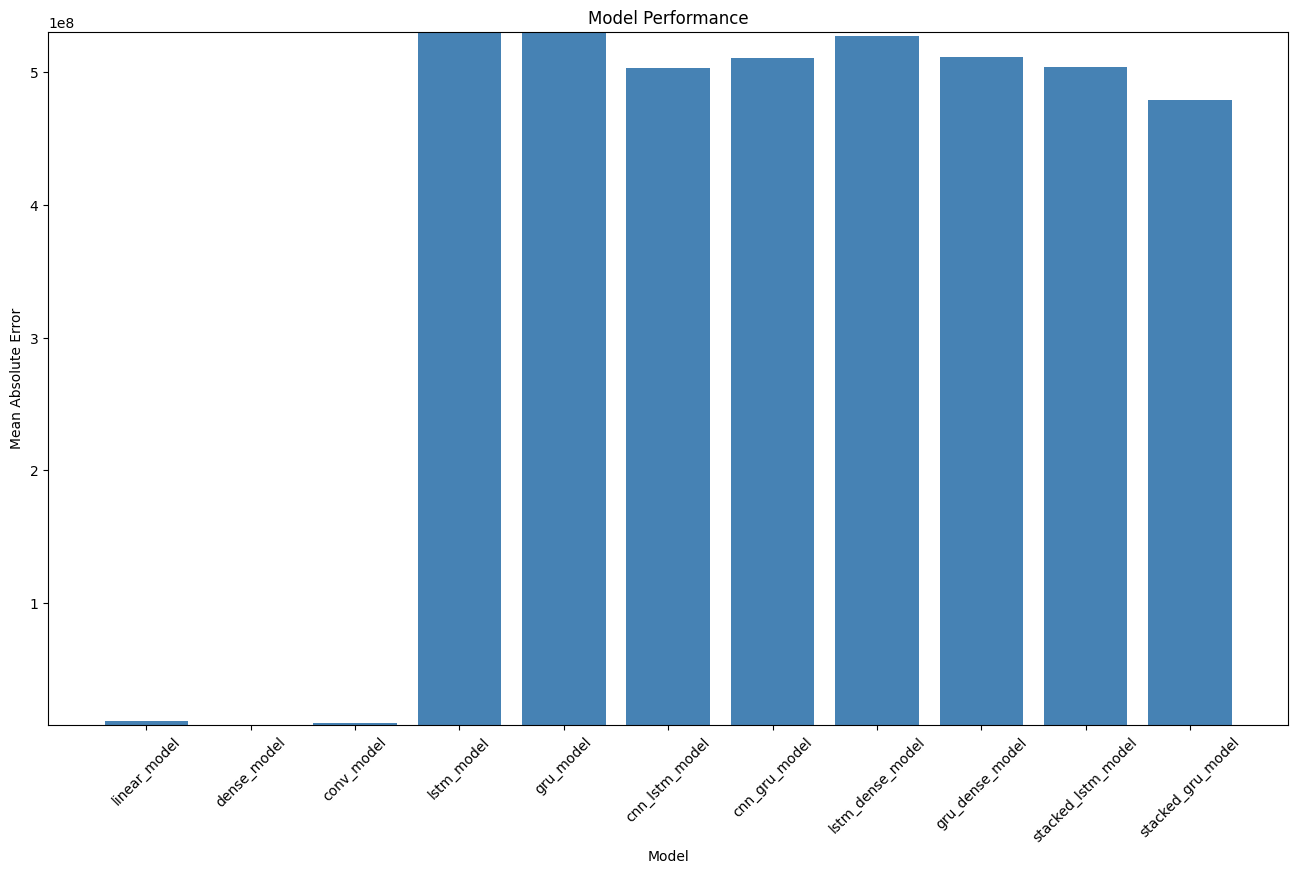

In [138]:
# Extract model names and scores
model_names = list(mae.keys())
scores = list(mae.values())

plt.figure(figsize=(16, 9))
plt.bar(model_names, scores, color='steelblue')
plt.xlabel('Model')
plt.ylabel('Mean Absolute Error')
plt.title('Model Performance')
plt.xticks(rotation=45)
plt.ylim(min(scores) - 1, max(scores) + 1)
plt.show()

In [139]:
mae

{'linear_model': 11017228.222,
 'dense_model': 8327609.297,
 'conv_model': 9720750.763,
 'lstm_model': 530262464.433,
 'gru_model': 529230143.027,
 'cnn_lstm_model': 503272159.152,
 'cnn_gru_model': 510474853.152,
 'lstm_dense_model': 527356546.402,
 'gru_dense_model': 511146967.152,
 'stacked_lstm_model': 503983427.152,
 'stacked_gru_model': 478992189.152}

In [140]:
min(mae.values())

8327609.297

In [141]:
results['y_test_actual'].mean().round(3)

530622545.152

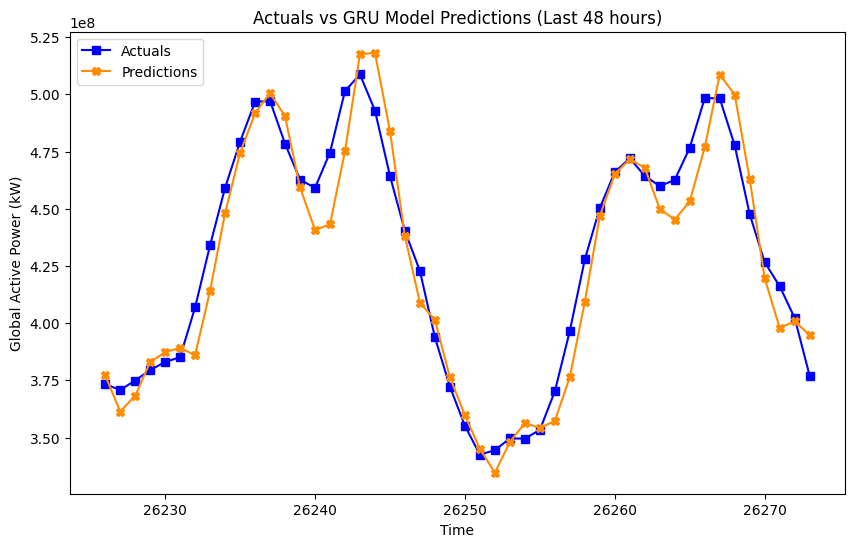

In [142]:
# Plotting the last 48 data points (48 hours) of train and test data
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(results['y_test_actual'].tail(48), color='b', marker='s')
ax.plot(results['linear_model_pred'].tail(48), color='darkorange', marker='X')
ax.set_title("Actuals vs GRU Model Predictions (Last 48 hours)")
ax.set_xlabel("Time")
ax.set_ylabel("Global Active Power (kW)")
ax.legend(["Actuals", "Predictions"])
plt.show()

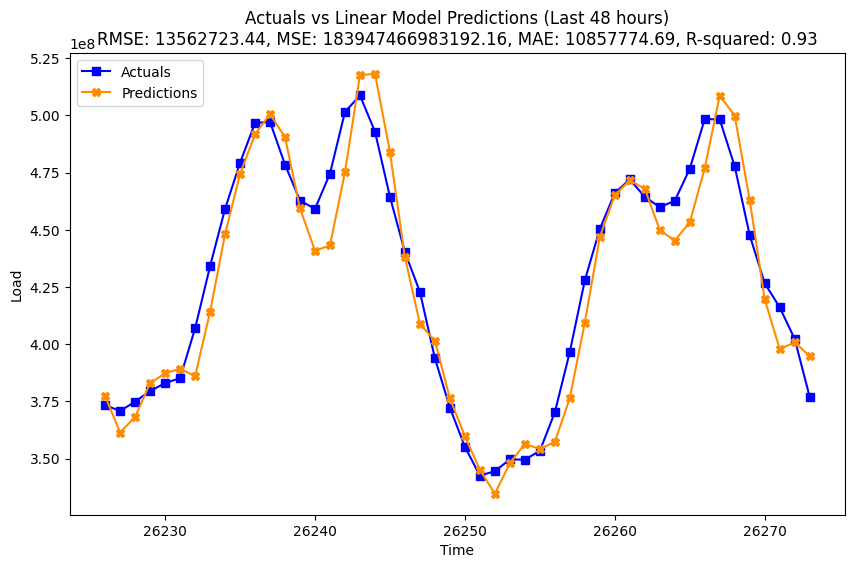

In [143]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate evaluation metrics
mse = mean_squared_error(results['y_test_actual'].tail(48), results['linear_model_pred'].tail(48))
mae = mean_absolute_error(results['y_test_actual'].tail(48), results['linear_model_pred'].tail(48))
rmse = np.sqrt(mse)
r_squared = r2_score(results['y_test_actual'].tail(48), results['linear_model_pred'].tail(48))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(results['y_test_actual'].tail(48), color='b', marker='s')
ax.plot(results['linear_model_pred'].tail(48), color='darkorange', marker='X')
ax.set_title(f"Actuals vs Linear Model Predictions (Last 48 hours)\nRMSE: {rmse:.2f}, MSE: {mse:.2f}, MAE: {mae:.2f}, R-squared: {r_squared:.2f}")
ax.set_xlabel("Time")
ax.set_ylabel("Load")
ax.legend(["Actuals", "Predictions"])
plt.show()


In [144]:
from keras.models import Sequential
from keras.layers import InputLayer, Flatten, Dense

# Assuming linear_model is your trained Sequential model
linear_model.save('linear_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
